# Comparison of different relevance methods

In [85]:
import torch
from torch import nn
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import ProvLRP
import ProvLRP_config
from importlib import reload
reload(ProvLRP)

import pandas as pd
import seaborn as sn

In [86]:
# Load dataset

train = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

BATCH_SIZE = 32

train_dataloader = DataLoader(
    train,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    test,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [87]:
# Select the best device to use

if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(f'Using device: {device}')

Using device: mps


In [88]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    return correct / len(y_pred) * 100

def train_model(model, optimizer, loss_fn):
    torch.manual_seed(42)
    epochs = 1#3

    for epoch in range(epochs):
        print(f"[EPOCH {epoch+1}/{epochs}] ", end="")
        train_loss = 0

        for batch, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)
            model.train()

            y_pred = model(X)

            loss = loss_fn(y_pred, y)
            train_loss += loss

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

        train_loss /= len(train_dataloader)

        test_loss, test_acc = 0, 0
        model.eval()
        with torch.inference_mode():
            for X, y in test_dataloader:
                X, y = X.to(device), y.to(device)
                test_pred = model(X)

                test_loss += loss_fn(test_pred, y)
                test_acc += accuracy_fn(y, test_pred.argmax (dim=1))

            test_loss /= len(test_dataloader)
            test_acc /= len(test_dataloader)

        print(f"Train loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

In [89]:
# Build the model
inputs = 784
hidden1 = 300
hidden2 = 100
outputs = 10

assert(outputs == len(train.classes))

model = nn.Sequential(
    nn.Flatten(),
    nn.ReLU(),
    nn.Linear(inputs, hidden1),
    nn.ReLU(),
    nn.Linear(hidden1, hidden2),
    nn.ReLU(),
    nn.Linear(hidden2, outputs)
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

train_model(model, optimizer, loss_fn)

[EPOCH 1/1] Train loss: 0.35041 | Test loss: 0.14091, Test acc: 95.87%


In [90]:
SUBSET = 20

X = train.data.reshape((60000, 784)).detach().numpy()
X = X[:SUBSET]
T = train.targets.detach().numpy()
T = T[:SUBSET]

In [91]:
# Extract weights and biases of trained MLP
layers = list(filter(None, [layer if isinstance(layer, nn.Linear) else None for layer in model.children()]))
W = [layer.weight.to('cpu').detach().numpy().T for layer in layers]
B = [layer.bias.to('cpu').detach().numpy().T for layer in layers]
L = len(W)

In [92]:
# Forward pass
A = [X] + [None] * L
for l in range(L):
    A[l+1] = np.maximum(0, A[l].dot(W[l])+B[l])

In [93]:
nb_digits = len(train.classes)

### Classical LRP
Using custom rules for each layer and $z^\mathcal{B}$ rule

In [94]:
R_classical_LRP = [None] * L + [A[L] * (T[:,None]==np.arange(nb_digits))]

def rho(w,l):  return w + [None,0.1,0.0,0.0][l] * np.maximum(0,w)
def incr(z,l): return z + [None,0.0,0.1,0.0][l] * (z**2).mean()**.5+1e-9

# All layers except the pixels one
for l in range(1, L)[::-1]:
    w = rho(W[l], l)
    b = rho(B[l], l)

    z = incr(A[l].dot(w)+b, l)
    s = R_classical_LRP[l+1] / z
    c = s.dot(w.T)
    R_classical_LRP[l] = A[l] * c

w = W[0]
wp = np.maximum(0, w)
wm = np.minimum(0, w)
lb = A[0]*0.-1
hb = A[0]*0.+1

z = A[0].dot(w)-lb.dot(wp)-hb.dot(wm)+1e-9
s = R_classical_LRP[1]/z
c, cp, cm = s.dot(w.T), s.dot(wp.T), s.dot(wm.T)
R_classical_LRP[0] = A[0]*c - lb*cp - hb*cm

### Without $z^\mathcal{B}$

In [95]:
semiring = ProvLRP.Semiring
def rho(w, l):  return w
R_wozB = [None] * L + [semiring.from_relevance(A[L] * (T[:,None]==np.arange(nb_digits)))]

# All layers, even the pixels one
for l in range(0, L)[::-1]:
    w = rho(semiring.from_weight(W[l]), l)

    s = R_wozB[l+1]
    c = s.dot(w.T)
    R_wozB[l] = semiring.from_activation(A[l]) * c

R_wozB = [semiring.semiring_to_float(x) for x in R_wozB]

### Boolean semiring

In [96]:
reload(ProvLRP)
reload(ProvLRP_config)
semiring = ProvLRP.BooleanSemiring

ProvLRP_config.boolean_relevance_threshold = 0.5

ProvLRP_config.boolean_activation_threshold = 1
ProvLRP_config.boolean_weight_threshold = 0

R_bool = [None] * L + [semiring.from_relevance(A[L] * (T[:,None]==np.arange(nb_digits)))]

# All layers, even the pixels one
for l in range(0, L)[::-1]:
    w = rho(semiring.from_weight(W[l]), l)

    s = R_bool[l+1]
    c = s.dot(w.T)
    R_bool[l] = semiring.from_activation(A[l]) * c

R_bool = [semiring.semiring_to_float(x) for x in R_bool]

### Counting semiring

In [97]:
reload(ProvLRP)
reload(ProvLRP_config)
semiring = ProvLRP.CountingSemiring

ProvLRP_config.counting_relevance_threshold = 0.5
ProvLRP_config.counting_activation_threshold = 0.1
ProvLRP_config.counting_weight_threshold = 0

R_count = [None] * L + [semiring.from_relevance(A[L] * (T[:,None]==np.arange(nb_digits)))]

# All layers, even the pixels one
for l in range(0, L)[::-1]:
    w = rho(semiring.from_weight(W[l]), l)

    s = R_count[l+1]
    c = s.dot(w.T)
    R_count[l] = semiring.from_activation(A[l]) * c

R_count = [semiring.semiring_to_float(x) for x in R_count]

### Viterbi semiring

In [98]:
# Forward pass
A = [X] + [None] * L
for l in range(L):
    A[l+1] = np.maximum(0, A[l].dot(W[l])+B[l])

R_vit = [None] * L + [A[L] * (T[:,None]==np.arange(nb_digits))]

# All layers even the pixels one
for l in range(0, L)[::-1]:
    R_vit[l] = np.zeros((SUBSET,A[l].shape[1]))
    Z = np.zeros((R_vit[l].shape[1], R_vit[l+1].shape[1], SUBSET))

    for j in range(R_vit[l].shape[1]):
        for k in range(R_vit[l+1].shape[1]):
            Z[j][k] = (A[l][:,j] * W[l][j,k] + B[l][k]) * W[l][j,k]

    sums = np.max(Z, axis=0)

    for j in range(R_vit[l].shape[1]):
        s = []#np.zeros_like(Z[0][0])
        for k in range(R_vit[l+1].shape[1]):
            s.append(Z[j][k]/sums[k] * R_vit[l+1][:,k])
        R_vit[l][:,j] = np.max(s, axis=0)

### Image perturbations

In [99]:
SUBSET = 1000

X = train.data.reshape((60000, 784)).detach().numpy()
X = X[:SUBSET]
T = train.targets.detach().numpy()
T = T[:SUBSET]

In [100]:
def evaluate_attack(subset, kernel_size, step, annotate_image):
    kx_range = range(0, 28, step)
    ky_range = range(0, 28, step)

    accuracies = [np.zeros((len(kx_range), len(ky_range))) for _ in range(10)]
    losses = [np.zeros((len(kx_range), len(ky_range))) for _ in range(10)]

    for digit in range(10):
        for i, kx in enumerate(kx_range):
            for j, ky in enumerate(ky_range):
                attack = datasets.MNIST(
                    root="data",
                    train=False,
                    download=True,
                    transform=Lambda(
                        lambda x: annotate_image(kx, ky, kernel_size, ToTensor()(x).squeeze())
                    ),
                )
                attack = torch.utils.data.Subset(attack, range(subset))

                #image, _ = attack[0]
                #plt.imshow(image.squeeze(), cmap="gray")
                #plt.title(label)
                #plt.show()

                attack_loader = DataLoader(
                    torch.utils.data.Subset(attack, [i for i, (_, y) in enumerate(attack) if y == digit]),
                    batch_size=BATCH_SIZE,
                    shuffle=False
                )

                test_loss, test_acc = 0, 0
                model.eval()
                with torch.inference_mode():
                    for X, y in attack_loader:
                        X, y = X.to(device), y.to(device)
                        test_pred = model(X)

                        test_loss += loss_fn(test_pred, y)
                        test_acc += accuracy_fn(y, test_pred.argmax (dim=1))

                    if len(attack_loader) != 0:
                        test_loss /= len(attack_loader)
                        test_acc /= len(attack_loader)

                accuracies[digit][j][i] = test_acc
                losses[digit][j][i] = test_loss

    return accuracies, losses

SUBSET = 1000
KERNEL_SIZE = 4
STEP = 1

def invert_attack(kx, ky, kernel_size, image):
    h = kernel_size//2
    image[ky-h:ky+kernel_size-h, kx-h:kx+kernel_size-h] = 1 - image[ky-h:ky+kernel_size-h, kx-h:kx+kernel_size-h]
    return image

accuracies, losses = evaluate_attack(SUBSET, KERNEL_SIZE, STEP, invert_attack)

In [101]:
accuracies = [100 - a for a in accuracies]

## Comparison of the methods

In [118]:
def normalize(img):
    #return img / np.linalg.norm(img)
    return (img - np.min(img)) / (np.max(img) - np.min(img))

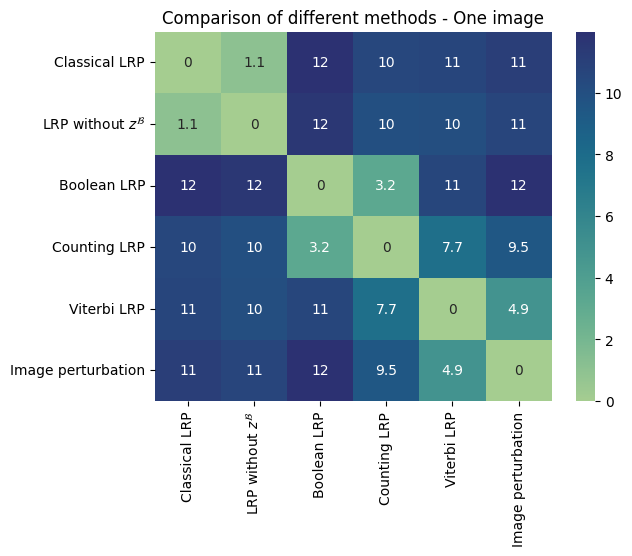

In [131]:
relevances = [R_classical_LRP, R_wozB, R_bool, R_count, R_vit]
labels = ["Classical LRP", "LRP without $z^\mathcal{B}$", "Boolean LRP", "Counting LRP", "Viterbi LRP", "Image perturbation"]

images = [r[0][0].reshape((28, 28)) for r in relevances] + [accuracies[0]]

images = [normalize(img) for img in images]

matrix = [[np.linalg.norm(a-b) for a in images] for b in images]


df_cm = pd.DataFrame(matrix, labels, labels)
sn.heatmap(df_cm, annot=True, cmap="crest")
plt.title("Comparison of different methods - One image")
plt.show()

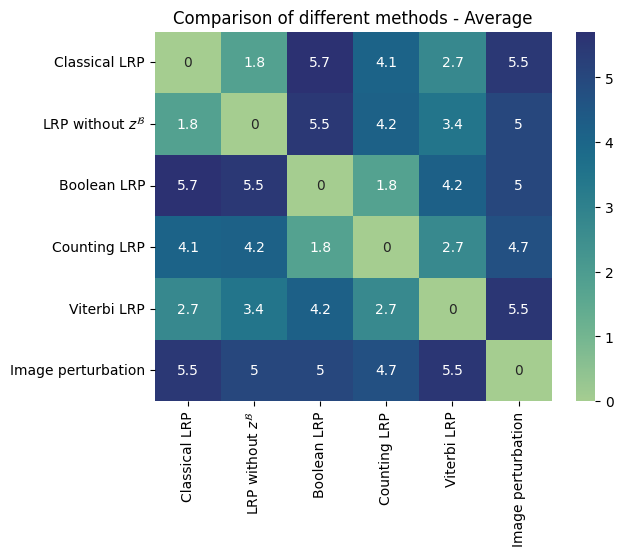

In [122]:
relevances = [R_classical_LRP, R_wozB, R_bool, R_count, R_vit]
labels = ["Classical LRP", "LRP without $z^\mathcal{B}$", "Boolean LRP", "Counting LRP", "Viterbi LRP", "Image perturbation"]

images = [np.mean(r[0], axis=0).reshape((28, 28)) for r in relevances] + [np.mean(accuracies, axis=0)]

images = [normalize(img) for img in images]

matrix = [[np.linalg.norm(a-b) for a in images] for b in images]


df_cm = pd.DataFrame(matrix, labels, labels)
sn.heatmap(df_cm, annot=True, cmap="crest")
plt.title("Comparison of different methods - Average")
plt.show()